In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'benchmark_lapa',
        root = '..'
    )

In [2]:
from pathlib import Path 
import pandas as pd
import numpy as np
import pyranges as pr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from lapa.result import LapaResult
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve

In [3]:
results = dict()

for i in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    results[f'{library_prep} {platform}'] = LapaResult(i, replicated=False)

In [4]:
thresholds = dict()

for i in snakemake.input['lapa_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    thresholds[f'{library_prep} {platform}'] = LapaResult(i).read_clusters()['count'].min()

In [5]:
core_cols = ['Chromosome', 'Start', 'End', 'Strand']

In [6]:
df_quantseq = LapaResult(snakemake.input['quantseq'][0]) \
    .read_clusters().drop_duplicates(core_cols)
df_quantseq = df_quantseq[df_quantseq['signal'].str.endswith('@AATAAA')]
df_quantseq = df_quantseq[df_quantseq['tpm'] > 5]

gr_quantseq = pr.PyRanges(df_quantseq, int64=True)

In [7]:
def join_outer(gr1, gr2, suffix):
    return gr1.join(gr2, strandedness='same', how='outer', suffix=suffix)

In [8]:
def benchmark(results):
    _benchmark = dict()

    for k, result in tqdm(results.items()):  
        df = result.read_clusters().drop_duplicates(core_cols)

        df = df[df['signal'].str.endswith('@AATAAA')]
        gr =  pr.PyRanges(df, int64=True)
        df = join_outer(gr_quantseq, gr, f'_{k}').df

        _benchmark[k] = df
    
    return _benchmark

In [9]:
results_benchmark = benchmark(results)

  0%|                                                                                                                                                                                                                                                                 | 0/6 [00:00<?, ?it/s]/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 5/6 [00:16<00:03,  3.07s/it]/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

In [10]:
def overlap_precision_recall(df, label):
    ground_truth = list((df['polyA_site'] != -1).astype(int))
    score = df[f'tpm_{label}'].replace(-1, 0)

    prec, recall, threshold = precision_recall_curve(
        ground_truth, score, pos_label=1)
    prec[0] = 0

    return pd.DataFrame({
        'data source': f'{label}={int(round(auc(recall, prec) * 100))}%',
        'Precision': prec,
        'Recall': recall,
        'threshold': [0] + threshold.tolist()
    })

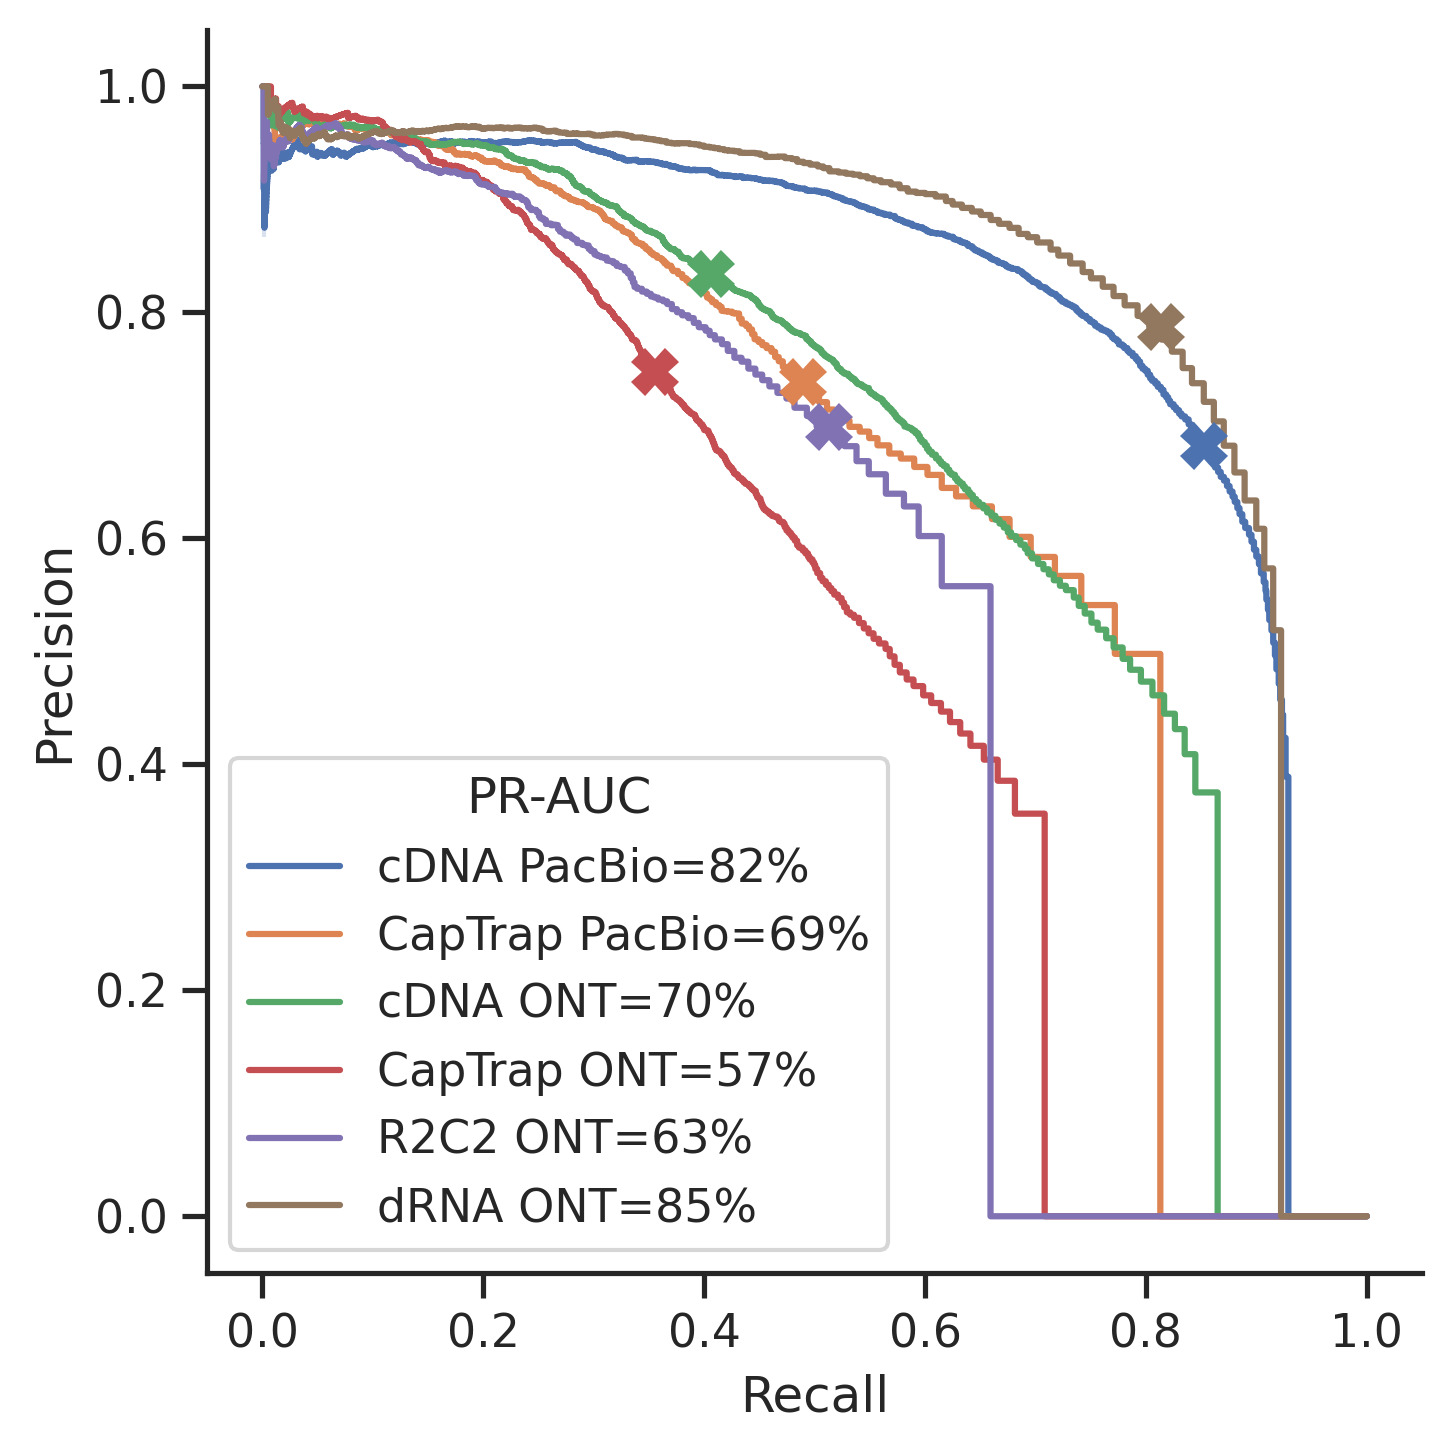

In [11]:
plt.figure(figsize=(5, 5), dpi=300)


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

df_benchmark = list()

df_performance = list()

for label, df in results_benchmark.items():    
    _df = overlap_precision_recall(df, label)
    row = _df[_df['threshold'] > thresholds[label]].iloc[0]
    
    df_performance.append({
        'Recall': row['Recall'], 
        'Precision': row['Precision'],
        'Data Source': label
    })
    
    plt.plot(row['Recall'], row['Precision'], 'X', 
             markersize=10, zorder=10)
    
    df_benchmark.append(_df)

df_benchmark = pd.concat(df_benchmark).reset_index(drop=True)
df_performance = pd.DataFrame(df_performance)

ax = sns.lineplot(data=df_benchmark, y='Precision', x='Recall', 
             hue='data source', 
             drawstyle='steps-pre')

plt.legend()._legend_box.align='right'

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.legend(loc='lower left', title='PR-AUC')

plt.savefig(snakemake.output['pr_curve_plot'], bbox_inches = "tight")

In [12]:
df_performance.to_csv(snakemake.output['pr_table'], index=False)
df_performance

,Recall,Precision,Data Source
0,0.852165,0.682092,cDNA PacBio
1,0.489438,0.738593,CapTrap PacBio
2,0.406448,0.833830,cDNA ONT
3,0.355482,0.746878,CapTrap ONT
4,0.513217,0.698884,R2C2 ONT
5,0.813993,0.786981,dRNA ONT


In [13]:
df_performance.mean()

/tmp/ipykernel_34010/2774241216.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_performance.mean()


Recall       0.571791
Precision    0.747876
dtype: float64

In [14]:
results_tail = dict()

for i in snakemake.input['lapa_tail_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    results_tail[f'{library_prep} {platform}'] = LapaResult(i, replicated=False)

In [15]:
thresholds_tail = dict()

for i in snakemake.input['lapa_tail_dir']:
    library_prep, platform, _ = Path(i).name.split('_')
    thresholds_tail[f'{library_prep} {platform}'] = LapaResult(i).read_clusters()['count'].min()

In [16]:
results_benchmark_tail = benchmark(results_tail)

  0%|                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  s

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scdf = scdf.append(sh)
/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pyranges/methods/join.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ocdf = ocdf.append(oh)
/pub/mcelik/anac

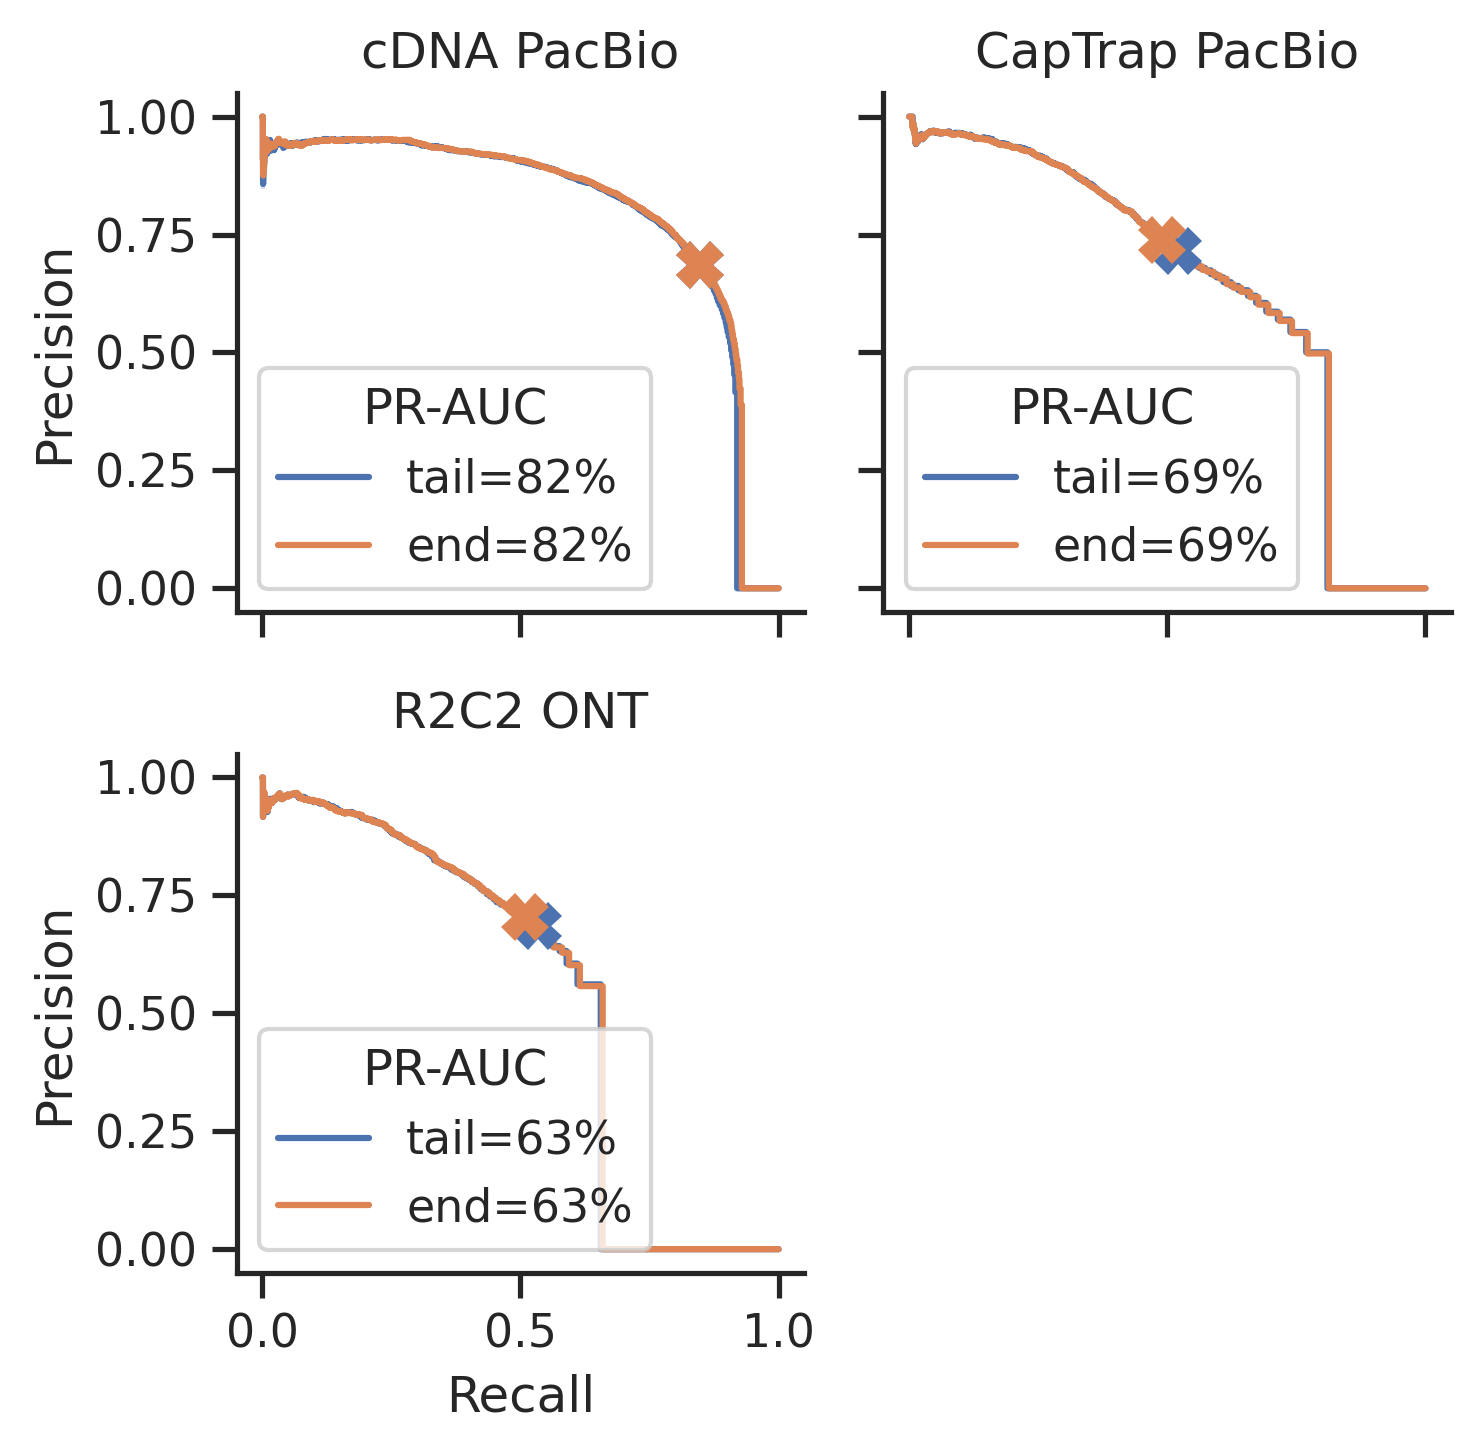

In [17]:
from more_itertools import flatten

fig, axs = plt.subplots(figsize=(5, 5), dpi=300, nrows=2, ncols=2, sharex=True, sharey=True)
axs = list(flatten(axs))

platform_protocol = ['cDNA PacBio', 'CapTrap PacBio', 'R2C2 ONT']

for ax in axs:
    ax.set_axis_off()

for ax, label in zip(axs, platform_protocol):

    ax.set_title(label)
    
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    _df_tail = overlap_precision_recall(results_benchmark_tail[label], label)
    _df_tail['data source'] = _df_tail['data source'].map(lambda x: x.replace(label, 'tail'))

    _df_end = overlap_precision_recall(results_benchmark[label], label)
    _df_end['data source'] = _df_end['data source'].map(lambda x: x.replace(label, 'end'))

    _df = pd.concat([_df_tail, _df_end]).reset_index(drop=True)

    row = _df[_df['threshold'] > thresholds_tail[label]].iloc[0]
    ax.plot(row['Recall'], row['Precision'], 'X', markersize=10, zorder=10)

    row = _df[_df['threshold'] > thresholds[label]].iloc[0]
    ax.plot(row['Recall'], row['Precision'], 'X', markersize=10, zorder=10)

    sns.lineplot(data=_df.rename(columns={'data source': 'PR-AUC'}), 
                 y='Precision', x='Recall', hue='PR-AUC', 
                 drawstyle='steps-pre', ax=ax)

    ax.set_axis_on()

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.tight_layout()

plt.savefig(snakemake.output['pr_curve_counting'], bbox_inches = "tight")

In [18]:
from collections import defaultdict

df_overlap = pd.DataFrame({})

paths = [
    snakemake.input['quantseq'][0],
    *snakemake.input['lapa_dir']
]

for i in tqdm(paths):
    
    result_i = LapaResult(i)
    gr_i =  pr.PyRanges(result_i.read_clusters())
    gr_i = gr_i[gr_i.signal.str.endswith('@AATAAA')]
    gr_i = gr_i[gr_i.tpm > 5]

    library_prep, platform, _ = Path(i).name.split('_')
    name_i = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

    for j in paths:
        result_j = LapaResult(j)
        gr_j =  pr.PyRanges(result_j.read_clusters())

        gr_j = gr_j[gr_j.signal.str.endswith('@AATAAA')]

        library_prep, platform, _ = Path(j).name.split('_')
        name_j = f'{library_prep} {platform}'.replace('quantseq Illumina', 'Quantseq3')

        df = gr_i.nearest(gr_j, strandedness='same', suffix=f'_{j}').df
        
        df = df[df['Distance'] < 1]

        df_overlap.loc[name_i, name_j] = df.shape[0] / gr_i.df.shape[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:58<00:00,  8.35s/it]


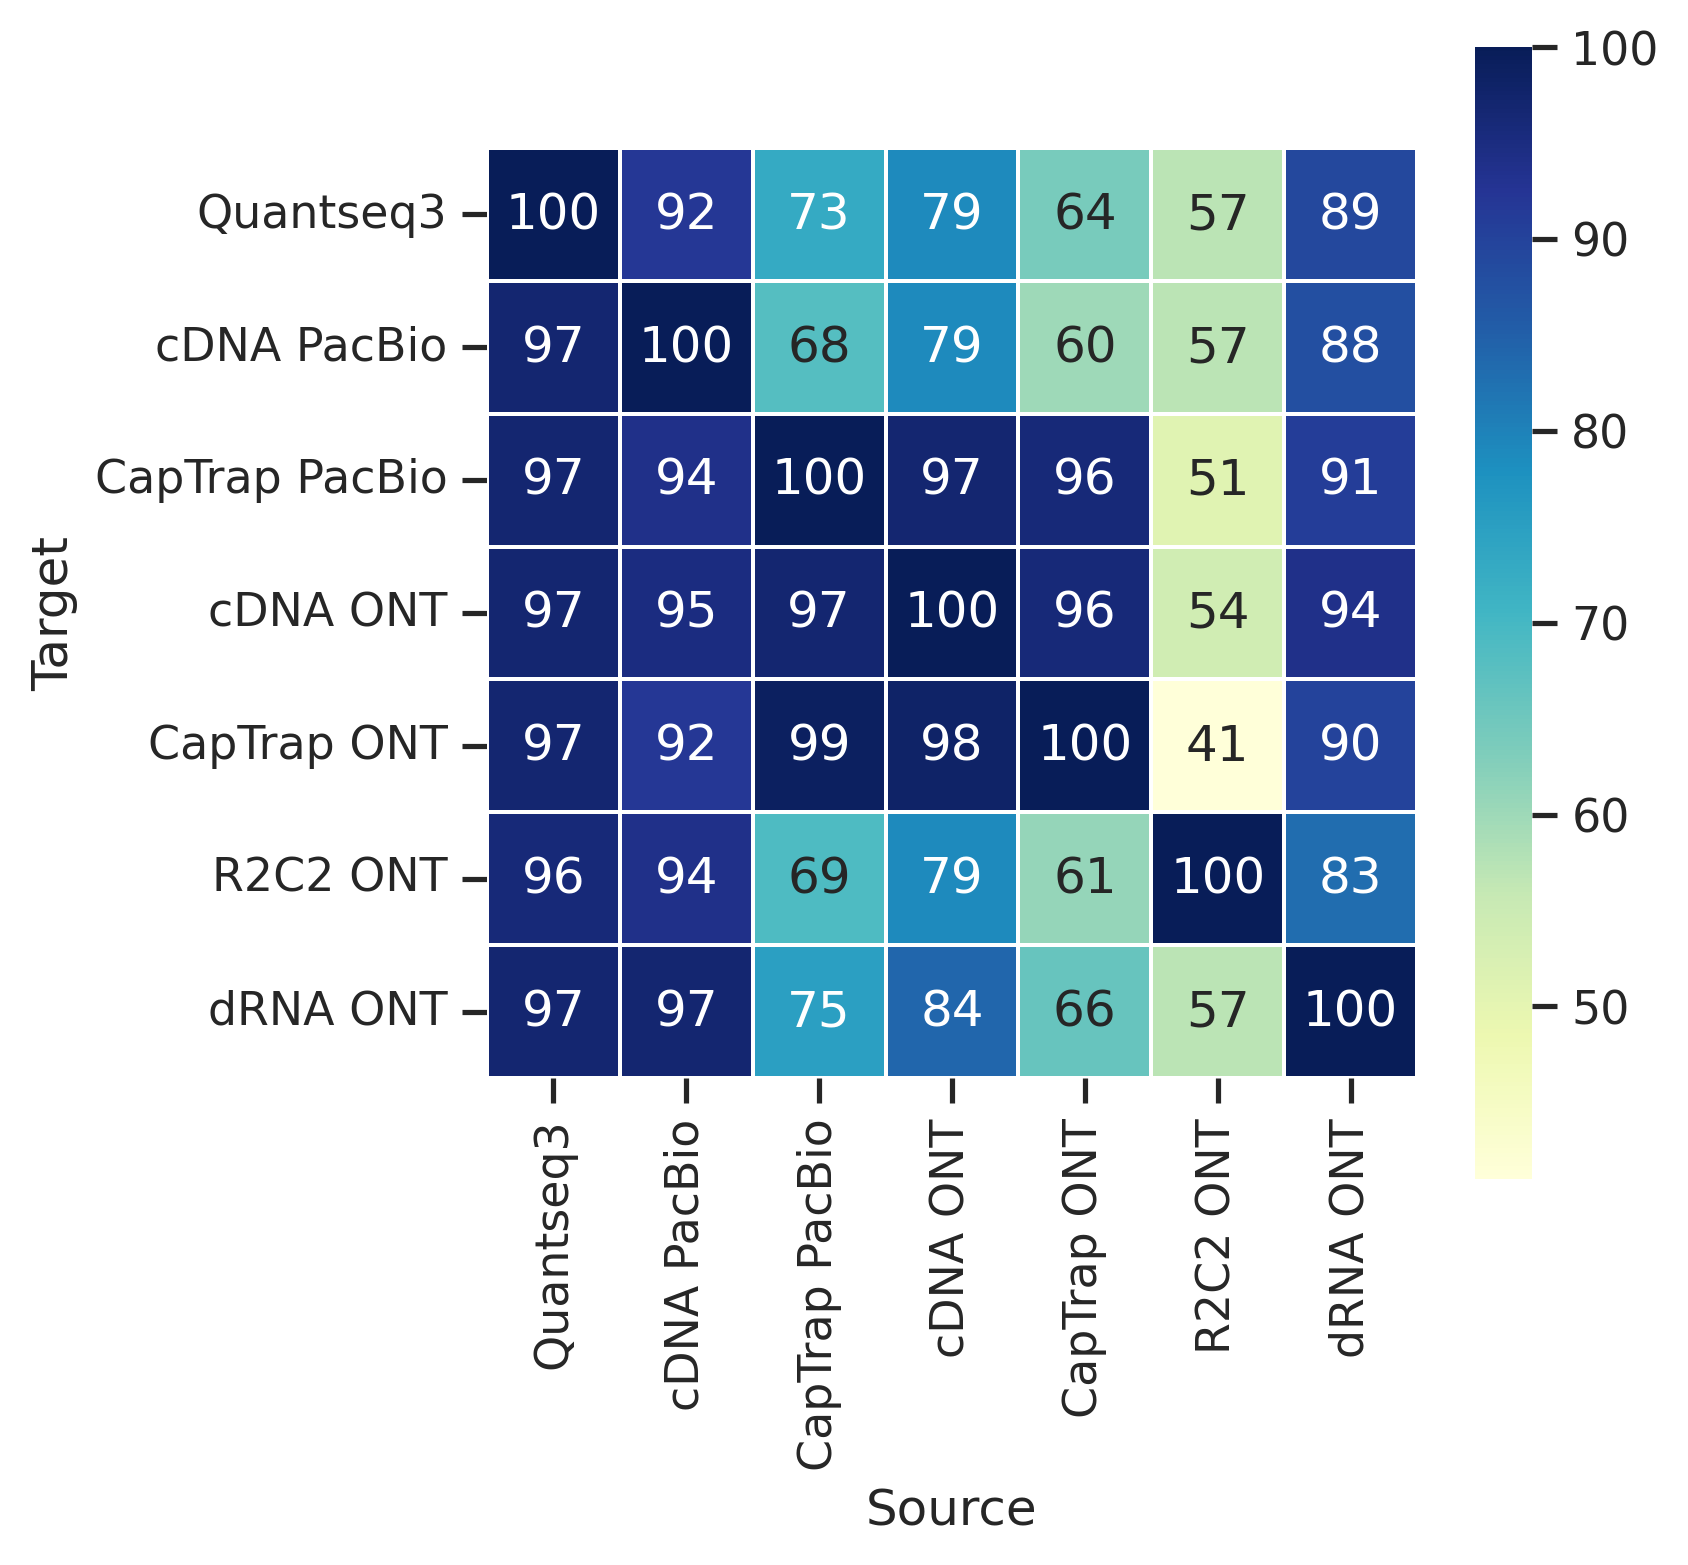

In [19]:
plt.figure(dpi=300, figsize=(5, 5))

sns.heatmap((df_overlap * 100).astype(int), annot=True, square=True,
            fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Source')
plt.ylabel('Target')
plt.savefig(snakemake.output['heatmap'], bbox_inches = "tight")